# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
# os.chdir("/home/morg/students/yoavgurarieh/")
# os.chdir("/Users/yoga/checkouts/lm_reg/")
sys.path.append("CausalAbstraction")

In [3]:
import logging

logging.getLogger("transformers.configuration_utils").setLevel(logging.ERROR)
import transformers

transformers.logging.set_verbosity_error()

import pandas as pd
from training import (
    sample_answerable_question_template,
    get_counterfactual_datasets,
    ppkn_simpler_counterfactual_template_split_key_loc,
)
from grammar.task_to_causal_model import multi_order_multi_schema_task_to_lookbacks_generic_causal_model
from grammar.schemas import SCHEMA_BOXES

from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm as _tqdm
import torch

# HF_TOKEN = "..." # HF
# from huggingface_hub import login
# login(token=HF_TOKEN)

# Run

#### Configure

In [ ]:
schema = SCHEMA_BOXES
num_instances = 20
num_samples = 3000

cat_indices_to_query = [0]
cat_to_query = 1

model_id = "google/gemma-2-2b-it"

layer = 18
cat_to_query = 1
generate=False


#### Run

In [5]:
causal_model = multi_order_multi_schema_task_to_lookbacks_generic_causal_model([schema], num_instances, num_fillers_per_item=0, fillers=False)
causal_models = {schema.name: causal_model}

counterfactual_template = ppkn_simpler_counterfactual_template_split_key_loc

train_ds, test_ds, fps = get_counterfactual_datasets(
    None,
    [schema],
    num_samples=num_samples,
    num_instances=num_instances,
    cat_indices_to_query=cat_indices_to_query,
    answer_cat_id=cat_to_query,
    do_assert=True,
    do_filter=False,
    counterfactual_template=counterfactual_template,
    causal_models=causal_models,
    sample_an_answerable_question=sample_answerable_question_template,
)

model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.bfloat16, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
from tasks.dist import get_end_str, format_prompt, to_str_tokens, to_single_token, run_with_cf_hf, try_schema_checker

results = {
    "normal": [],
    "cf": [],
    "source_pos": [],
    "positional_index": [],
    "keyload_index": [],
    "payload_index": [],
    "layer": [],
    "prediction": [],
    "positional_prediction": [],
    "payload_prediction": [],
    "keyload_prediction": [],
    "no_effect_prediction": [],
    "patch_effect": [],
    "dist": [],
    "distance": [],
    "generated": [],
}
train = train_ds[schema.name][schema.name]

token_positions = [-1]
end_str = get_end_str(model_id)

for cur_index in _tqdm(range(num_samples)):
    prompt = format_prompt(tokenizer, train[cur_index]["input"]["raw_input"])
    cf_prompt = format_prompt(tokenizer, train[cur_index]["counterfactual_inputs"][0]["raw_input"])
    prompt_str_tokenized = to_str_tokens(tokenizer, prompt)
    metadata = train[cur_index]["input"]["metadata"]

    answer_indices = []
    keyload_index = None
    payload_index = None
    for i, token in enumerate(prompt_str_tokenized):
        if "qwen" in model_id.lower() and i < 10:
            continue

        if schema.matchers[cat_to_query](token):
            answer_indices.append(i)

            if prompt_str_tokenized[i].lower().strip() in metadata["keyload"].lower().strip():
                keyload_index = len(answer_indices) - 1

            if prompt_str_tokenized[i].lower().strip() in metadata["payload"].lower().strip():
                payload_index = len(answer_indices) - 1

    assert (
        len(answer_indices) == num_instances
    ), f"Expected {num_instances} answer indices, got {len(answer_indices)}.\nPrompt_str_tokenized: {prompt_str_tokenized}.\n{[prompt_str_tokenized[i] for i in answer_indices]}."
    assert (
        keyload_index is not None
    ), f"Keyload [{metadata['keyload']}] index is None. Prompt_str_tokenized: {prompt_str_tokenized}.\n{[prompt_str_tokenized[i] for i in answer_indices]}."

    assert (
        payload_index is not None
    ), f"Payload [{metadata['payload']}] index is None. Prompt_str_tokenized: {prompt_str_tokenized}.\n{[prompt_str_tokenized[i] for i in answer_indices]}."

    pos_index = metadata["dst_index"]

    with run_with_cf_hf(
        model, tokenizer, prompt, cf_prompt, layer_idx=layer, token_positions=token_positions, alpha=1
    ):
        input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)
        logits = model(input_ids).logits
        values = logits[0, -1, [to_single_token(tokenizer, prompt_str_tokenized[i]) for i in answer_indices]]

        pos_pred = values.argmax().item()

        if generate:
            pred_ids = model.generate(input_ids, max_new_tokens=schema.max_new_tokens, do_sample=False)
            pred = tokenizer.decode(pred_ids[0], skip_special_tokens=True)
            pred = pred[pred.find(end_str) + len(end_str) :]
        else:
            pred = prompt_str_tokenized[answer_indices[pos_pred]]

        if try_schema_checker(pred, metadata["positional"], schema):
            patch_effect = "positional"
        elif try_schema_checker(pred, metadata["keyload"], schema):
            patch_effect = "lexical"
        elif try_schema_checker(pred, metadata["payload"], schema):
            patch_effect = "reflexive"
        elif try_schema_checker(pred, metadata["no_effect"], schema):
            patch_effect = "no_effect"
        else:
            patch_effect = "mixed"

        results["normal"].append(prompt)
        results["cf"].append(cf_prompt)
        results["source_pos"].append(metadata["src_positional_index"])
        results["positional_index"].append(pos_index)
        results["keyload_index"].append(keyload_index)
        results["payload_index"].append(payload_index)
        results["layer"].append(layer)
        results["positional_prediction"].append(metadata["positional"])
        results["payload_prediction"].append(metadata["payload"])
        results["keyload_prediction"].append(metadata["keyload"])
        results["no_effect_prediction"].append(metadata["no_effect"])
        results["patch_effect"].append(patch_effect)
        results["prediction"].append(pred)
        results["dist"].append(values.tolist())
        results["distance"].append(pos_index - pos_pred)
        results["generated"].append(generate)

print("[+] Finished getting dist")
df = pd.DataFrame(results)

100%|██████████| 3000/3000 [02:22<00:00, 21.06it/s]

[+] Finished getting dist


#### Plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(<Figure size 1000x600 with 1 Axes>,
 <Axes: xlabel='Patched Entity Group Index', ylabel='Patch Effect'>)

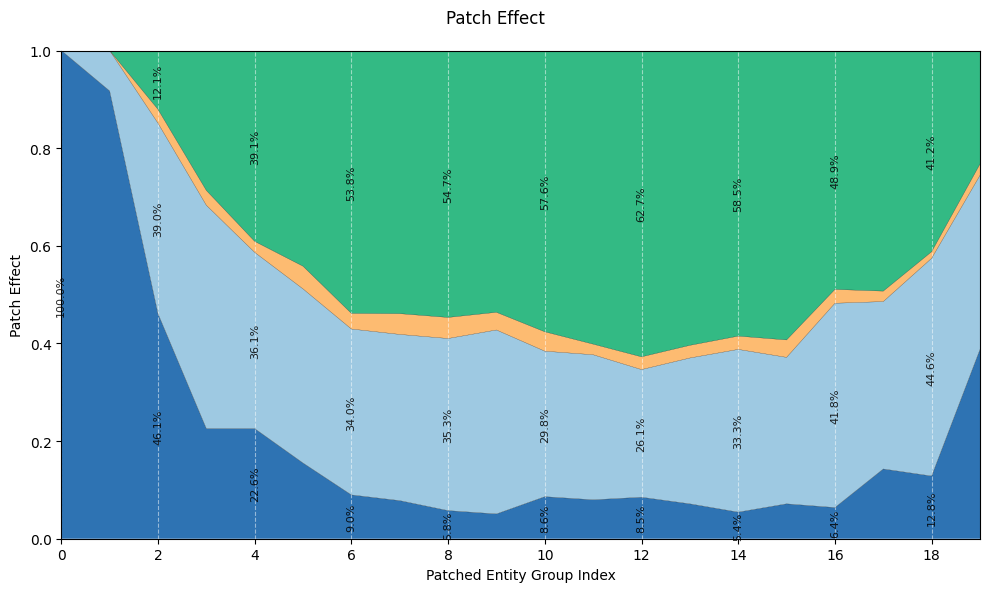

In [7]:
from plotting import plot_patch_effect
plot_patch_effect(df, include_reflexive=True, highest_near_pos=0)